The dataset required for the tasks can be found here:

http://busibud.com/ml_tasks.zip



For this task, we would prefer if you worked on a notebook format for all of the tasks you need to undertake, including data cleaning, transformation, numerical simulation, statistical modeling, data visualization, machine learning, etc. Please make sure it is as expressive as possible.



Task

Here you would need to create a model which assigns a customer to a certain customer category based on the total value of orders they’ve placed. This would let us target the most valuable customers with certain offers which promote a higher spend.

The dataset is a CSV, where each row represents an sku which is a part of an order. The different columns are described below. Every conversation included has at least one request from a consumer and at least one response from a company. Which user IDs are company user IDs can be calculated using the inbound field.

Content
InvoiceNo
A single invoice number represents one order that was placed. There might be multiple rows for the same invoice number, representing the different SKUs that were ordered.


StockCode
This represents the sku for the particular item that was ordered.


Description
This describes the exact item that was ordered in words.


Quantity
The quantity of the specific sku that was ordered.


InvoiceDate
This is the date the order was placed.


UnitPrice
This is the price of the particular sku that was ordered.


CustomerID
An anonymized ID of the customer who placed the order.

In [223]:
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor,XGBClassifier   #xgboost package is required
from category_encoders.ordinal import OrdinalEncoder  #category_encoders package is required
# from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV  # sklearn package required
from sklearn.cluster import AgglomerativeClustering,k_means,DBSCAN # sklearn package required
from sklearn.preprocessing import PowerTransformer,MinMaxScaler

## loading the data and understand it.

In [2]:
Xdata = pd.read_csv("data.csv")

In [3]:
Xdata.shape

(541909, 8)

In [4]:
Xdata.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
# function to check missing columns in the dataset
def find_missing(Xdata):
    """
    Xdata: dataframe
    return sorted missing values columns of given dataset.
    """ 
    from IPython.display import display
    missing_values_columns = [[col,Xdata[col].isnull().sum(),Xdata[col].dtypes] for col in Xdata.columns if Xdata[col].isnull().any()]
    display(sorted(missing_values_columns, key=(lambda k:k[1])),len(missing_values_columns))
    
# convert Invoice date into 4 different features 
def date_to_features(df,c_n):
    """
    df: dataframe
    c_n: column name of datetime type
    
    """
    df['Invoice_Year'] = pd.to_datetime(df[c_n]).dt.year
    df['Invoice_month'] = pd.to_datetime(df[c_n]).dt.month
    df['Invoice_day'] = pd.to_datetime(df[c_n]).dt.day
    df['Invoice_time'] = pd.to_datetime(df[c_n]).dt.time

In [6]:
find_missing(Xdata)

[['Description', 1454, dtype('O')], ['CustomerID', 135080, dtype('float64')]]

2

In [7]:
Xdata.UnitPrice.min(),Xdata.UnitPrice.max()  # check value range of CustomerID

(-11062.06, 38970.0)

### Some information about the dataset we found are
1. Dataset has 541909 rows 
2. InvoiceNo feature has 25900 unique entries and 3710 unique entries when CustomerID null.
3. StockCode feature has 4070 unique entries means total 4070 items in stock

    3.1 StockCode startwith digit only help in our problem others are charges or discount or various fees as given in description
    
4. Description feature has 4223 unique entries meaning 1 stockcode may have different description: ex: white or cream product have same stockcode
5. Qunatity feature has values from -80995 to 80995

    5.1 There are 5172 Invoices with negative values has corresponding 1589 CustomersId ( excluding null)
    
    5.2 Total of 2559 type of stocks but (as StockCode and description mentioned) negative quantity represents
    
        5.1.1 Discounts, Postage, Amazonfee, Samples, Bank Charges, Manual, CRUK Commission etc(delete these rows).
        5.2.2 negative also represent items returned. 

6. InvoiceDate range from 2010/12/01 to 2011/12/09(YYYY-MM-DD)
7. UnitPrice Range (-11062.06, 38970.0)

    7.1 **Some UnitPrie feature have 0 values delete those rows because they don't play a role in our output**
    
    7.2 **Negative UnitPrice mentioned in description is bad debt and no CustomerId so delete those rows also**
    
8. CustomerID has total 4373 unique numbers range between 12346-18287 (excluding null values)


### Data cleaning :

1. As mentioned in 5.1.1 delete stockcode not starting with digit
2. As mentioned in 7.1 and 7.2 delete less than or equal to zero UnitPrice cells.

NOTE: 
1. As we just have to categorise our customer based on total value of orders they’ve placed, important features for us are only Quantity and UnitPrice and CustomerID. (** our target is this **)

2. Other classification can be done based on StockCode and Description to helps us target the customer who spends on particular type of product.

3. or classification can be done based on InvoiceDate to helps us target the customer spends on particular day.

In [92]:
# follow point 5.1.1
Xdata = Xdata[Xdata.StockCode.str[0].str.isdigit()]

In [93]:
# follow point 7.1 and 7.2
Less_equal_UnitPrice = Xdata.loc[Xdata.UnitPrice<=0].index
Xdata = Xdata.drop(labels=Less_equal_UnitPrice)

In [94]:
#convert Invoice date into datetime format
Xdata.InvoiceDate = pd.to_datetime(Xdata.InvoiceDate,format="%m%d%Y %H:%M",infer_datetime_format=True)

### handling missing values

1. No need to deal with Null value of Description feature, already handled with our data cleaning. 
1. CustomerID has 131553 null values remaining

    1.1 either we remove all the rows with null value. (**I choose this**)
    
    1.2 or we can predict CustomerID using other features. (XGBoost algo is used for this)


In [95]:
Customer_id_null = Xdata.loc[Xdata.CustomerID.isnull()==True].index
Xdata_train = Xdata.drop(labels=Customer_id_null)
# Xdata_test = Xdata.loc[Xdata.CustomerID.isnull()==True] #if we used null value of customerId features

In [96]:
Xdata_train = Xdata_train.reset_index(drop=True)
# Xdata_test = Xdata_test.reset_index(drop=True) #if we used null value of customerId features

In [97]:
# to check weather our output is out of range or not
customer_id = set(Xdata_train.CustomerID)

In [105]:
# select the required features.
final_data = Xdata_train.loc[:,["Quantity","UnitPrice","CustomerID"]]

In [248]:
del(Xdata)
del(Xdata_train)

### data transformation(when rows of CustomerID with null value not removed)

Because CustomerID missing values must be predicted 

1. convert Invoice date into 4 different features which helps in categorization of customer and finding null value of CustomerID
2. apply label encoding on categorical features.

Note: drop InvoiceDate feature because too many categories only used for forcasting of sales not good for customer categorization

### data transformation (when rows of CustomerID with null value removed)

1. consider only 3 features (Quantity, UnitPrice, CustomerID) 
2. Add 1 more feature multiplying Qunatity and UnitPrice
3. apply groupby and aggregate function 

In [14]:
#if we used null value of customerId features and then following feature helps to predict the values for CustomerID

# date_to_features(Xdata_train,"InvoiceDate")
# date_to_features(Xdata_test,"InvoiceDate") 
# Xdata_train.reset_index(drop=True)
# Xdata_test.reset_index(drop=True)
# Xdata_train = Xdata_train.drop(labels="InvoiceDate",axis=1)
# Xdata_test = Xdata_test.drop(labels="InvoiceDate",axis=1) 
# cat_feature = ["InvoiceNo","StockCode","Description","Country","Invoice_Year","Invoice_month","Invoice_day","Invoice_time"]
# cat_encoder = OrdinalEncoder(cols=cat_feature)
# labeled_Xdata_train = cat_encoder.fit_transform(Xdata_train)
# labeled_Xdata_test = cat_encoder.transform(Xdata_test)  #if we used null value of customerId features

# xgboost_custmorID = XGBClassifier(early_stopping_rounds=10)
# grid = { 
#     'n_estimators': [100,200,300,400,500],
#     'max_features': ['sqrt', 'log2'],
#     'learning_rate': [0.1,0.2,0.3],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy'],
#     'random_state' : [18]
# }
# rf_cv = GridSearchCV(estimator=xgboost_custmorID, param_grid=grid)
# rf_cv.fit(X_train, y_train)
# rf_cv.best_params_
# scores = -1 * cross_val_score(rf_cv.best_estimator_, X_train, y_train,scoring='accuracy',cv=5,fit_params={'eval_set': [(X_val, y_val)],'verbose':False})
# print("Mean cross-validation score: %.2f" % scores.mean())
# predict = rf_cv.best_estimator_.predict(X_test)

In [214]:
final_data["Total_price"] = final_data.Quantity * final_data.UnitPrice

In [336]:
temp = final_data.groupby("CustomerID").agg(["sum","median","count"])

In [337]:
temp.columns = ['_'.join(x) for x in temp.columns]
temp = temp.reset_index(drop=False)

In [338]:
temp.head()  

,CustomerID,Quantity_sum,Quantity_median,Quantity_count,UnitPrice_sum,UnitPrice_median,UnitPrice_count,Total_price_sum,Total_price_median,Total_price_count
0,12346.0,0,0.0,2,2.08,1.040,2,0.00,0.00,2
1,12347.0,2458,12.0,182,481.21,2.015,182,4310.00,17.00,182
2,12348.0,2332,80.0,27,18.71,0.550,27,1437.24,41.76,27
3,12349.0,630,6.0,72,305.10,2.325,72,1457.55,17.70,72
4,12350.0,196,12.0,16,25.30,1.550,16,294.40,18.75,16


Note: sometimes Quantity_sum==0 but Total_price_sum!=0 but Quantity_sum==0 alone represents customer returned all the products he purchased. And 12 customers are there like them.

In [339]:
# select important features
# Qunatity_count means frequency with which buying
# Total_price_median means average order value
# Total_Price_sum means Total lifetime value (equivalent to UnitPrice_median and Quantity_sum)
temp = temp.loc[:,["CustomerID","Quantity_count","UnitPrice_median","Total_price_sum"]]
temp = temp.rename(columns={"Quantity_count":"frequency"})

In [340]:
temp.head()

,CustomerID,frequency,UnitPrice_median,Total_price_sum
0,12346.0,2,1.040,0.00
1,12347.0,182,2.015,4310.00
2,12348.0,27,0.550,1437.24
3,12349.0,72,2.325,1457.55
4,12350.0,16,1.550,294.40


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Total_price_sum'>

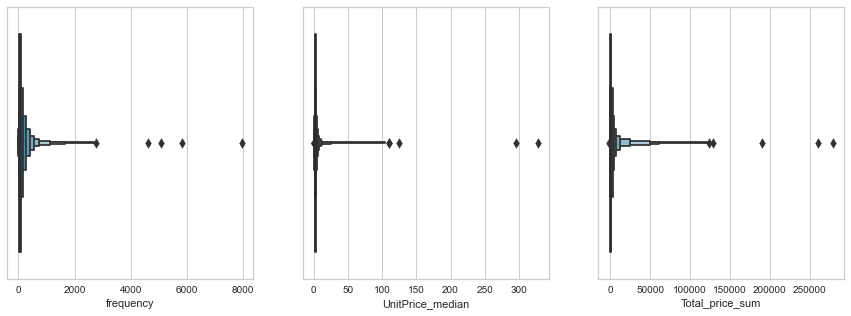

In [341]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.boxenplot(x = temp.frequency, ax=axes[0])
sns.boxenplot(x = temp.UnitPrice_median,ax=axes[1])
sns.boxenplot(x = temp.Total_price_sum,ax=axes[2])

from above graph we can see that there are outlier to handle
1. Some entries of frequency are high (8,000) i.e. very frequent customer (valuable customer)
2. Some entries of UnitPrice_median are high(300 dollar) i.e. expensive items are purchased by customer (valuable customer)
3. Some entries or Total_price_sum are too high (2,50,000) i.e. they are very valuable customers (can be wholesaler also)

### scaling and normalization

In [343]:
tranformer_p = PowerTransformer()
t = tranformer_p.fit_transform(temp)
temp1= pd.DataFrame(t,index=temp.index,columns=temp.columns)

scaler = MinMaxScaler()
temp_scaled = pd.DataFrame(scaler.fit_transform(temp1),
                   columns = temp1.columns,
                   index = temp1.index)

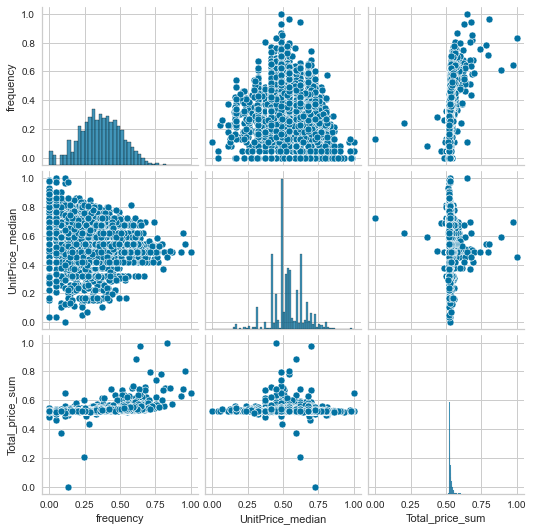

In [344]:
sns.pairplot(temp_scaled.drop(labels="CustomerID",axis=1)) #below graphs represent various customer behaviours

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Total_price_sum', ylabel='Count'>

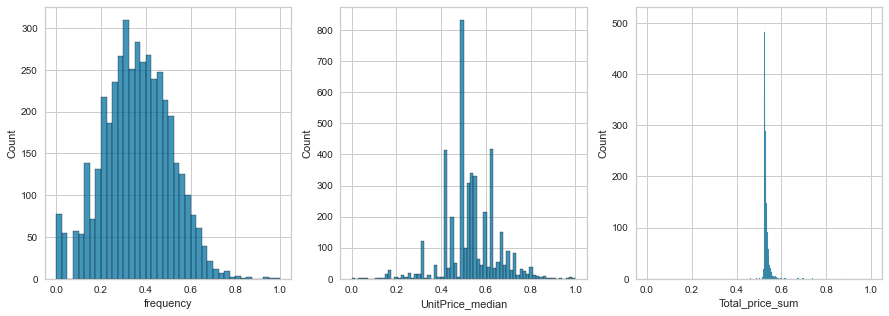

In [345]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.histplot(x = temp_scaled.frequency, ax=axes[0])
sns.histplot(x = temp_scaled.UnitPrice_median,ax=axes[1])
sns.histplot(x = temp_scaled.Total_price_sum,ax=axes[2])

## Clustering

In [346]:
Customer_ID = temp_scaled.CustomerID
temp_scaled = temp_scaled.drop(labels="CustomerID",axis=1)

from yellowbrick.cluster.elbow import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,30), metric='calinski_harabasz', timings=True
)

visualizer.fit(temp_scaled)        # Fit the data to the visualizer
visualizer.show()                  # Finalize and render the figure

<IPython.core.display.Javascript object>

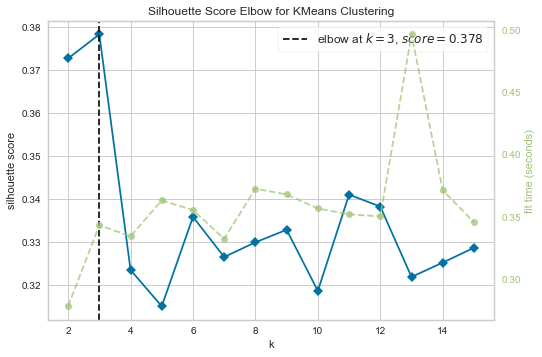

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [240]:
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,16), metric='silhouette', timings=True
)

visualizer.fit(temp_scaled)        # Fit the data to the visualizer
visualizer.show() 

clearly 3 clusters are showing better result here

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='UnitPrice_median', ylabel='Total_price_sum'>

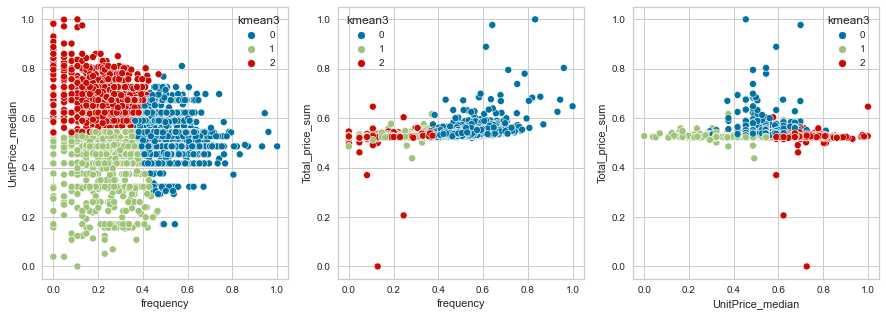

In [430]:
K_model = KMeans(n_clusters=3)
cluster_pred = K_model.fit_predict(temp_scaled)
Kmean_clusters3 = pd.DataFrame(cluster_pred,index=Customer_ID.index,columns=["kmean3"])
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.scatterplot(x=temp_scaled.frequency,y=temp_scaled.UnitPrice_median,hue=Kmean_clusters3.kmean3,palette=sns.color_palette(n_colors=3),ax=axes[0])
sns.scatterplot(x=temp_scaled.frequency,y=temp_scaled.Total_price_sum,hue=Kmean_clusters3.kmean3,palette=sns.color_palette(n_colors=3),ax=axes[1])
sns.scatterplot(x=temp_scaled.UnitPrice_median,y=temp_scaled.Total_price_sum,hue=Kmean_clusters3.kmean3,palette=sns.color_palette(n_colors=3),ax=axes[2])

#### By looking at graph we can find out which customer are more valuable

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='UnitPrice_median', ylabel='Total_price_sum'>

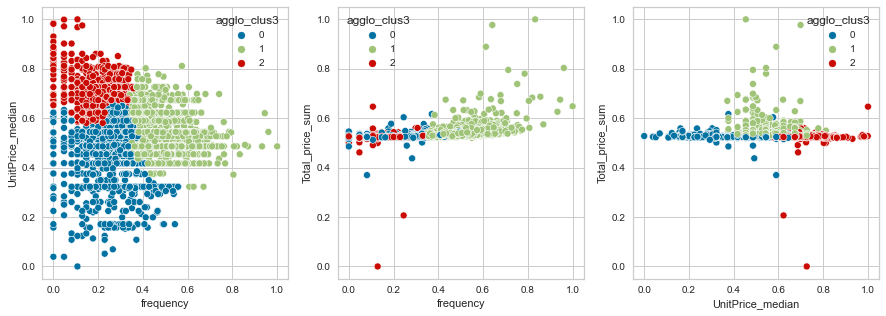

In [417]:
model = AgglomerativeClustering(n_clusters=3)
cluster_pred = model.fit_predict(temp_scaled)
Aggl_clust3 = pd.DataFrame(cluster_pred,index=Customer_ID.index,columns=["agglo_clus3"])
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.scatterplot(x=temp_scaled.frequency,y=temp_scaled.UnitPrice_median,hue=Aggl_clust3.agglo_clus3,palette=sns.color_palette(n_colors=3),ax=axes[0])
sns.scatterplot(x=temp_scaled.frequency,y=temp_scaled.Total_price_sum,hue=Aggl_clust3.agglo_clus3,palette=sns.color_palette(n_colors=3),ax=axes[1])
sns.scatterplot(x=temp_scaled.UnitPrice_median,y=temp_scaled.Total_price_sum,hue=Aggl_clust3.agglo_clus3,palette=sns.color_palette(n_colors=3),ax=axes[2])

dbscan and gaussian mixture model are not good model for our problem.

In [418]:
silhouette_score(temp_scaled,model.labels_)

0.3381729568157602

## so our best model is K_model with 3 clusters 

In [432]:
output = pd.concat([temp.CustomerID,Kmean_clusters3],axis=1)  
# 0 means most valuable customers
# 2 means second most valuable customers (rare but buy expensive items)
# 1 means least valuable customers

# these 0/1/2 categories meaning change everytime we execute the code so follow k-mean graph to understand

In [434]:
output.head()

,CustomerID,kmean3
0,12346.0,1
1,12347.0,0
2,12348.0,1
3,12349.0,0
4,12350.0,1
